# Traffic Sign Classification with Keras

Keras exists to make coding deep neural networks simpler. To demonstrate just how easy it is, you’re going to use Keras to build a convolutional neural network in a few dozen lines of code.

You’ll be connecting the concepts from the previous lessons to the methods that Keras provides.

## Dataset

The network you'll build with Keras is similar to the example in Keras’s GitHub repository that builds out a [convolutional neural network for MNIST](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). 

However, instead of using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, you're going to use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset that you've used previously.

You can download pickle files with sanitized traffic sign data here:

In [1]:
import numpy as np
import pandas as pd

fileloc = 'Center_Lap_01/'
fileloc2 = 'Off_Track_02/'
csvfilename = fileloc + 'driving_log.csv'
csvfilename2 = fileloc2 + 'driving_log.csv'
hd = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
df1 = pd.read_csv(csvfilename, names = hd)
print(df1['center'][1][70:])
df2 = pd.read_csv(csvfilename2, names = hd)
print(df2['center'][1][70:])

# print(df2[0])



df = df1.append(df2, ignore_index=True)

# numpy_array = df.as_matrix()
original_headers = list(df.columns.values)
print(original_headers)


print(df['center'][2][70:])

print(df['steering'][1298])
print(df['steering'][1:10])
# print(df['steering'][8035])
print(df['center'][0:3])

print(df.shape)
print(df2.shape)

Center_Lap_01/IMG/center_2017_02_22_19_53_05_041.jpg
Off_Track_02/IMG/center_2017_02_22_20_09_02_131.jpg
['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
Center_Lap_01/IMG/center_2017_02_22_19_53_05_107.jpg
-0.4
1    0.00
2    0.00
3    0.00
4    0.00
5    0.00
6    0.00
7    0.00
8    0.00
9   -0.05
Name: steering, dtype: float64
0    /home/mahesh/udacity/CarND-Behavioral-Cloning-...
1    /home/mahesh/udacity/CarND-Behavioral-Cloning-...
2    /home/mahesh/udacity/CarND-Behavioral-Cloning-...
Name: center, dtype: object
(8653, 7)
(2086, 7)


In [2]:
print(df['center'][80])

/home/mahesh/udacity/CarND-Behavioral-Cloning-P3/beta_simulator_linux/Center_Lap_01/IMG/center_2017_02_22_19_53_11_210.jpg


<class 'numpy.ndarray'>
(160, 320, 3)


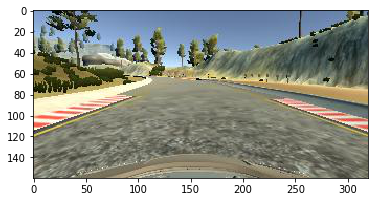

In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
imnum = [10, 13, 19]

fname = [df['center'][i][70:] for i in imnum]
# fname2 = [df2['center'][i][70:] for i in imnum]




# im1 = cv2.imread(filename1)[::1]
im = [cv2.imread(f)[...,::-1] for f in fname]



im_crop = np.array([image[60:140,:] for image in im])

print(type(im[0]))
print(im[0].shape)
# plt.figure(figsize=(1,1))
plt.imshow(im[0])

## Resize

X train size:  (3, 50, 50, 3)
y train size:  (3,)
[-0.25      -0.8500001 -0.05     ]


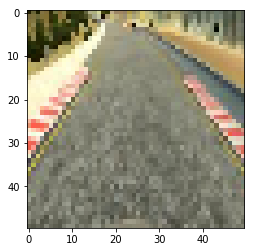

In [4]:
new_size = (32,32)

im_resized = np.array([cv2.resize(image, (50,50)) for image in im_crop])#, fx=0.25, fy=0.5) 

X_traindemo = im_resized
y_traindemo = np.array([df['steering'][i] for i in imnum])
# plt.figure(figsize=(1,1))
plt.imshow(im_resized[0])
print('X train size: ', X_traindemo.shape)

print('y train size: ', y_traindemo.shape)
print(y_traindemo)

## Overview

Here are the steps you'll take to build the network:

1. Load the training data.
2. Preprocess the data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate the final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [5]:

# import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


## Load the Data

Start by importing the data from the pickle file.

In [7]:
from sklearn.utils import shuffle
imnum = range(int(df.shape[0]/5))
print(max(imnum))

fname = [df['center'][i][70:] for i in imnum]



# im1 = cv2.imread(filename1)[::1]
# im = [cv2.imread(f)[...,::-1] for f in fname]


# X_train = image_preprocess([cv2.imread(f)[...,::-1] for f in fname])
X_train = np.array(([cv2.imread(f)[...,::-1] for f in fname]))
y_train = np.array([df['steering'][i] for i in imnum])

# X_train2 = [np.fliplr(image) for image in X_train]
# y_train2 = -y_train

# X_train = np.concatenate([X_train2, X_train])
# y_train = np.concatenate([y_train2, y_train])


for i in range(2):
    X_train, y_train = shuffle(X_train, y_train)
    
print(X_train.shape)
print(y_train.shape)
# print(y_train)


1729
(1730, 160, 320, 3)
(1730,)


## Generator & data augmentation

In [8]:
# i = 0
# def generate_data(X_train, y_train, batchsize):
#     istart = 0
#     batchsize = len(y_train)//(len(y_train)//batchsize)
#     while True:
        
#         iend = istart + batchsize
#         istart = iend
#         yield (X_train[istart:iend], y_train[istart:iend])

## Train the Network

1. Compile the network using adam optimizer and categorical_crossentropy loss function.
2. Train the network for ten epochs and validate with 20% of the training data.

In [9]:
# TODO: Re-construct the network and add dropout after the pooling layer.
from keras.models import Sequential
from keras.layers import Dropout, Convolution2D, MaxPooling2D, Lambda, Cropping2D 
from keras.layers.core import Dense, Activation, Flatten

nb_filters = 20
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
input_shape = (160, 320,3)
pool_size = (2, 2)
# model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
#                         border_mode='valid',
#                         input_shape=input_shape))
model = Sequential()
model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=input_shape))
model.add(Lambda(lambda x: -0.5 + x/255.0))

model.add(Convolution2D(nb_filters, 5, 5))
# model.add(MaxPooling2D(pool_size=pool_size))
          
model.add(Convolution2D(nb_filters, 5, 5))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Convolution2D(nb_filters, 3, 3))
model.add(Convolution2D(nb_filters, 3, 3))
model.add(MaxPooling2D(pool_size=pool_size))




model.add(Convolution2D(nb_filters, 3, 3))
model.add(MaxPooling2D(pool_size=pool_size))
          
model.add(Dropout(0.50))
model.add(Activation('relu'))
          
model.add(Flatten())
model.add(Dense(600))
model.add(Activation('relu'))
model.add(Dense(190))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(25))
model.add(Activation('relu'))
model.add(Dense(1))

# model.add(Activation('softmax'))

Using TensorFlow backend.


In [10]:
print(len(y_train))

1730


In [ ]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
# from keras.layers.core import Dense, Activation, Flatten, Dropout
# from keras.layers.convolutional import Convolution2D
# from keras.layers.pooling import MaxPooling2D
def generate_data(batchsize):
    istart = 0
#     batchsize = len(y_train)//(len(y_train)//batchsize)
    while True:
        for i in range(57):
            
            iend = istart + batchsize
            istart = iend
            print("Number of batchstart:", istart, batchsize)
            yield (X_train[istart:iend], y_train[istart:iend])


# model.compile('adam', 'categorical_crossentropy', ['accuracy'])
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
# history = model.fit(X_train, y_train, batch_size=128*2, nb_epoch=2, validation_split=0.25)
history = model.fit_generator(generate_data(30), samples_per_epoch = len(y_train), nb_epoch = 2) #, verbose=2, callbacks=[], validation_data=None, class_weight=None, nb_worker=1)

Number of batchstart:Epoch 1/2
 30 30
Number of batchstart: 60 30
Number of batchstart: 90 30
Number of batchstart: 120 30
Number of batchstart: 150 30
Number of batchstart: 180 30
Number of batchstart: 210 30
Number of batchstart: 240 30
Number of batchstart: 270 30
Number of batchstart: 300 30
Number of batchstart: 330 30


## Optimization
Congratulations! You've built a neural network with convolutions, pooling, dropout, and fully-connected layers, all in just a few lines of code.

Have fun with the model and see how well you can do! Add more layers, or regularization, or different padding, or batches, or more training epochs.

What is the best validation accuracy you can achieve?

In [ ]:
# TODO: Build a model
preds = model.predict(X_train[1190:1310])
print("Pred = ", preds.T, "\nSteering angle = ", y_train[1190:1310])
# TODO: Compile and train the model

**Best Validation Accuracy:** (fill in here)

## Testing
Once you've picked out your best model, it's time to test it.

Load up the test data and use the [`evaluate()` method](https://keras.io/models/model/#evaluate) to see how well it does.

Hint 1: The `evaluate()` method should return an array of numbers. Use the [`metrics_names`](https://keras.io/models/model/) property to get the labels.

In [ ]:


# TODO: Evaluate model on test data
# test_score = model.evaluate(X_normalized_test, y_one_hot_test)
val_score = model.evaluate(X_train, y_train)

print(val_score)

**Test Accuracy:** (84.37)

## Save Model

In [ ]:
from keras.models import load_model

model.save('model_user_trainigdata_generator_06.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# model = load_model('model_trial_allsampledata_02.h5')

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.

### Hello

second
third